# ASCE 7-10 Calculations
This notebook is for carrying out seismic calculations to ASCE 7-10.

** **Work in Progress** **
Corrently being converted from ASCE41-17 notebook

## Utilities

In [32]:
from math import log, pi, sin, cos, tan, acos, asin, atan, atan2
from itertools import accumulate


#import pandas as pd
def printt(table, h1 = 20, h2 = 12):
    """
    Printing tables where first column is text and the remainder are floats
    h1 is the 
    """
    for line in table:
        print('{:20s}'.format(line[0]), end = ' ')
        [print('{:8.4f}'.format(item), end = ' ') for item in line[1:]]
    return None


def interp(x, x1, x2, y1, y2):
    if y1 is None or y2 is None:
        return None
    elif x1 == x2:
        return 0.5 * (y1 + y2)
    else:
        return y1 + (x - x1) / (x2 - x1) * (y2 - y1)


def list_interp(val, list_1, list_2):
    """Returns interpolated values from list_2 based on values related to list_1, returning the bookends if the 
    provided values are outside the range of list_1
    val is the lookup value
    list_1 is the lookup list
    list_2 is the result list with values corresponding to those on list_1
    """
    i_list = [i for i, n in enumerate(list_1) if n == val]
    if i_list:
        return list_2[i_list[0]]
    elif val <= list_1[0]:
        return list_2[0]
    elif val >= list_1[-1]:
        return list_2[-1]
    else:
        index_list = [i for i, (x1, x2) in enumerate(zip(list_1[:-1], list_1[1:])) if val >= x1 and val <= x2]
        if len(index_list) == 1:
            j = index_list[0]
            return interp(val, list_1[j], list_1[j+1], list_2[j], list_2[j+1])
        else:
            return None


def k_gen(T):
    """Returns the coefficient for the vertical distribution of lateral force (Eq 4-2a)"""
    return max(1.0, min(2.0, 0.5 * T + 0.75))


def storey_force_coeffs(elev_list, weight_list, k = 1.0):
    """
        Inputs:
            elev_list - list of storey elevations (m)
          weight_list - list of storey weights (kN)
    """
    divisor = sum(w * h**k for w, h in zip(weight_list, elev_list))
    return [w * h**k / divisor for w, h in zip(weight_list, elev_list)]


def storey_force_distribution(V, elev_list, weight_list, k = 1.0):
    """
        Inputs:
            V  - base shear in kN
            elev_list - list of storey elevations (m)
          weight_list - list of storey weights (kN)
    """
    divisor = sum(w * h**k for w, h in zip(weight_list, elev_list))
    return [w * h**k * V / divisor for w, h in zip(weight_list, elev_list)]


def storey_forces(force_list, rev = True):
    """Returns a list of accumulated storey forces - i.e. storey shears
    NB lists have to be reversed before applying the accumulate function"""
    shear_list_rev = accumulate(force_list[::-1] if rev else force_list)
    return list(shear_list_rev)[::-1] if rev else list(shear_list_rev)


def storey_shear_moment(force_list, height_list, rev = True):
    """Returns a tuple of lists containing storey shear and storey moment
    (from ground up, increasing z if 'rev' is True)"""
    shear_list_rev = list(accumulate(force_list[::-1] if rev else force_list))
    v_h_rev = [v * h for v, h in zip(shear_list_rev, height_list[::-1] if rev else height_list)]
    mom_list_rev = list(accumulate([0]+v_h_rev[:-1]))
    return shear_list_rev[::-1] if rev else shear_list_rev, mom_list_rev[::-1] if rev else mom_list_rev


def shear_coords(elevs, shears):
    """Returns a list of (z,V) tuples for plotting storey shear diagrams
    Inputs are lists of elevations and shear values
    NB. Interleaving is required because of the steps in the shear diagram"""
    l_1 = list(zip(elevs[1:],shears[1:]))
    l_2 = list(zip(elevs,shears[1:] + [0.0]))
    out = []
    while l_2:
        out.append(l_2.pop()) if l_2 else None
        out.append(l_1.pop()) if l_1 else None
    return out[::-1]





## Seismic Hazard

In [45]:
C_t_dict = {'S1':0.035, 'S1a':0.035, 'C1':0.018, 'S2':0.030, 'S2a': 0.030}
C_t_get = lambda x: C_t_dict.get(x, 0.020)  # a lookup function that returns default of 0.020

beta_dict = {'S1':0.80, 'S1a':0.80, 'C1':0.90}
beta_get = lambda x: beta_dict.get(x, 0.75)  # a lookup function that returns default of 0.75

unit_l_dict = {'m': 1.0, 'cm': 0.01, 'mm':0.001, 'in':0.0254, 'ft':0.3048, 'yd':0.9144}
unit_l_get = lambda x: unit_l_dict.get(x, None)  # a lookup function that returns default of None

def T_code_get(s_type, height, units = 'm'):
    """Returns the code period in seconds for a given structure type and height Eqn 4-4"""
    C_t = C_t_get(s_type)
    beta = beta_get(s_type)
    u_fac = unit_l_get(units)
    ft_fac = unit_l_get('ft')
    return C_t * height ** beta if units == 'ft' else C_t * (u_fac / ft_fac * height) ** beta


B_1_func = lambda x: 4.0 / (5.6 - log(100 * x)) # for x as damping ratio (not percentage)

# F_a and F_v taken from ASCE7-10, tables 11.4-1 & 11.4-2
F_a_headers = (0.25,0.5,0.75,1.0,1.25,1.5)
F_v_headers = (0.1,0.2,0.3,0.4,0.5,0.6)
F_a_dict = {'A': (0.8,0.8,0.8,0.8,0.8,0.8),
           'B': (1.0,1.0,1.0,1.0,1.0,1.0),
           'C': (1.2,1.2,1.1,1.0,1.0,1.0),
           'D': (1.6,1.4,1.2,1.1,1.0,1.0),
           'E': (2.5,1.7,1.2,0.9,0.9,0.9),
           'F': (None,None,None,None,None,None)}
F_v_dict = {'A': (0.8,0.8,0.8,0.8,0.8,0.8),
           'B': (1.0,1.0,1.0,1.0,1.0,1.0),
           'C': (1.7,1.6,1.5,1.4,1.3,1.3),
           'D': (2.4,2.0,1.8,1.6,1.5,1.5),
           'E': (3.5,3.2,2.8,2.4,2.4,2.4),
           'F': (None,None,None,None,None,None)}


importance_factors_headers = ('I_s', 'I_i', 'I_w', 'I_e')
importance_factors_dict = {'I': (0.80, 0.80, 1.00, 1.00), 
                            'II': (1.00, 1.00, 1.00, 1.00), 
                            'III': (1.00, 1.10, 1.00, 1.25), 
                            'IV': (1.20, 1.25, 1.00, 1.50)}


def site_coeffs(site_class, S_s, S_1):
    """Returns F_a, F_v when provided with site class (A-F) and S_s and S_1 values"""
    F_a_list = F_a_dict[site_class]
    F_v_list = F_v_dict[site_class]
    return list_interp(S_s, F_a_headers, F_a_list), list_interp(S_1, F_v_headers, F_v_list)


def site_accels_M(site_class, S_s, S_1):
    """Returns S_MS, S_M1 when provided with site class (A-F) and S_s and S_1 values
    >>> site_accels_M(site_class, S_s, S_1)
    (0.468, 0.33)
    """
    F_a_list = F_a_dict[site_class]
    F_v_list = F_v_dict[site_class]
    F_a = list_interp(S_s, F_a_headers, F_a_list)
    F_v = list_interp(S_1, F_v_headers, F_v_list)
    return F_a * S_s, F_v * S_1


def seismicity_level_get():
    """Not implemented"""
    pass


def code_period(h_n, s_type):
    """Returns period in seconds when given height (h_n) in metres and ASCE41-17 structural type (e.g. 'C1')"""
    return C_t_get(s_type) * (h_n / 0.3048) ** beta_get(s_type)


def S_DS_get():
    S_DS = 2 / 3 * F_a * S_s
    pass


def S_a_get(T, S_s, S_1, site_class, T_L = 12.0):
    """Returns the spectral acceleration when provided with period (T), S_s, S_1 and site class
    using values for F_a & F_v from tables 11.4-1 & 11.4-2"""
    F_a, F_v = site_coeffs(site_class, S_s, S_1)
    S_DS = 2 / 3 * F_a * S_s
    S_D1 = 2 / 3 * F_v * S_1
    
    T_S = S_D1 / S_DS
    T_0 = 0.2 * T_s
    return min(S_DS, S_DS*(0.4 + 0.6*T/T_0), S_D1 / T) if T < T_L else T_L * S_D1 / (T**2.0)


def seismic_design_category_get(S_s, S_1, site_class, risk_category):
    """Returns the seismic design category based on the site 
    spectral accelerations, site class and risk category
    >>> seismic_design_category_get(0.75, 0.2, 'D', 'II')
    'D'
    >>> seismic_design_category_get(0.3, 0.15, 'C', 'II')
    'C'
    >>> seismic_design_category_get(0.18, 0.09, 'B', 'II')
    'A'
    """
    F_a, F_v = site_coeffs(site_class, S_s, S_1)
    S_DS = 2 / 3 * F_a * S_s
    S_D1 = 2 / 3 * F_v * S_1
    print('F_a, F_v:', F_a, F_v)
    print('S_DS, S_D1:', S_DS, S_D1)
    
    accel_limits_S = [0.0, 0.167, 0.33, 0.50]
    accel_limits_1 = [0.0, 0.067, 0.133, 0.20]
    
    if risk_category == 'IV':
        design_cat_list = ['A', 'C', 'D', 'D']
    else:
        design_cat_list = ['A', 'B', 'C', 'D']
    
    seismic_design_category_S = 'A'
    for S_lim, S_val in zip(accel_limits_S, design_cat_list):
        if S_DS >= S_lim:
            seismic_design_category_S = S_val
    
    seismic_design_category_1 = 'A'
    for S_lim, S_val in zip(accel_limits_1, design_cat_list):
        if S_D1 >= S_lim:
            seismic_design_category_1 = S_val
    
    print(seismic_design_category_S, seismic_design_category_1)
    seismic_design_category = max(seismic_design_category_S, seismic_design_category_1)
    
    if risk_category in ['I', 'II', 'III'] and S_1 >= 0.75:
        seismic_design_category = 'E'
    
    if risk_category == 'IV' and S_1 >= 0.75:
        seismic_design_category = 'F'
    
    return seismic_design_category



In [54]:
S_s, S_1 = 0.75, 0.2
S_s, S_1 = 1.2, 0.45
S_s, S_1 = 0.3, 0.15
#S_s, S_1 = 0.25, 0.1
#S_s, S_1 = 0.18, 0.09
site_class = 'D'
print(site_coeffs(site_class, S_s, S_1))
seismic_design_category_get(S_s, S_1, site_class, 'I')

(1.56, 2.2)
F_a, F_v: 1.56 2.2
S_DS, S_D1: 0.312 0.22
B D


'D'

In [2]:
'B' > 'A', max('F', 'X')

(True, 'X')

## Tier 1 Data & Functions

In [3]:
struct_types_dict = {
'S1': 'Steel MRF',
'S2': 'Steel Braced Frame',
'S3': 'LM',
'S4': 'RC SW',
'S5': 'URM INF',
'C1': 'RC MRF',
'C2': 'RC SW',
'C3': 'URM INF'}


M_s_dict = {'C1': {'CP':2.0, 'LS': 1.5, 'IO': 1.0},
            'C2': {'CP':4.5, 'LS': 3.0, 'IO': 1.5},
            'URM': {'CP':1.75, 'LS': 1.25, 'IO': 1.0}}


def M_s_func(name, perf):
    """Returns data from a dictionary of M_s
    inputs:
        name - the name of the system (currently a choice of 'C1', 'C2', 'URM')
        perf - performance level:
            'IO' - Immediate Occupancy
            'LS' - Life Safety
            'CP' - Collapse Prevention
    """
    return M_s_dict.get(name).get(perf)


table_4_2_headers = ('Start Year', 'End Year', 'Beams', 'Slabs and Columns', 'Walls')
table_4_2_ksi = ((1900, 1919, 2.0, 1.5, 1.0),
             (1920, 1949, 2.0, 2.0, 2.0),
             (1950, 1969, 3.0, 3.0, 2.5),
             (1970, 3000, 3.0, 3.0, 3.0))

table_4_3_headers = ('Start Year', 'End Year', 33, 40, 50, 60, 65, 70, 75)
table_4_2 = ((1911, 1959, 1, 1, 1, 0, 1, 0, 0),
             (1960, 1966, 1, 1, 1, 1, 1, 1, 1),
             (1967, 1987, 0, 1, 1, 1, 1, 1, 0),
             (1988, 3000, 0, 1, 1, 1, 1, 1, 1))


def v_j_avg_mf(n_c, n_f, V_j, A_c, M_s):
    """Returns 
    Inputs:
        n_c - number of columns
        n_f - number of frames in direction of loading
        V_j - storey shear (sect 4.4.2.2)
        A_c - sum of cross-sectional area of """
    return n_c/(n_c - n_f) * V_j / A_c / M_s


def D_r(k_b, k_c, h, E, V_c):
    """k_c = I_c / L_c
    NB This should be doubled if base of columns is pinned
    """
    return V_c * (k_b + k_c) / k_b / k_c * h / 12 / E


def v_j_avg_sw(V_j, A_w, M_s):
    return V_j / A_w / M_s

## Building Specific
Read data from CSV file into the notebook. 

Currently this notebook assumes that storeys and relevant data will be imported in the followng format:
> name, storey height (m), elevation (m), mass (kg)

It is also assumed that response spectrum input will be imported as (period (s), acceleration(g)) pairs 

In [4]:
from itertools import accumulate
from csv import reader, excel_tab
from tkinter import filedialog
from tkinter import *

root = Tk()
root.filename =  filedialog.askopenfilename(initialdir = "/",title = "Select file",filetypes = (("csv files","*.csv"),("all files","*.*")))
filepath = root.filename
root.destroy()

print (filepath)


C:/Users/andrew.mole/OneDrive - Arup/Source/JupyterSamples/pySeismic/WismaMC.csv


In [5]:
with open(filepath, newline='') as csvfile:
    csv_reader = reader(csvfile, dialect = 'excel')
    data = [r for r in csv_reader]
storey_data = [[a, float(b), float(c), float(d)] for a,b,c,d in data]

## Storey Geometrical & Load Data

In [6]:
#g_m_s_2 = 9.80665
g_m_s_2 = 9.81
storey_names, storey_heights_m, storey_elevs_m, storey_masses_kg  = zip(*storey_data)
storey_weights_kN = [g_m_s_2 * 0.001 * float(m) for m in storey_masses_kg]

height_m = max(storey_elevs_m)

total_mass_tonne = 0.001 * sum(storey_masses_kg)
total_weight_kN = sum(storey_weights_kN)

basic_f = 'Height is {:.2f}m, total mass is {:8,.0f} tonne, total weight is {:8,.0f} kN\n'
print(basic_f.format(height_m, total_mass_tonne, total_weight_kN))

tit_f = '{:20s} {:9s} {:10s} {:10s} {:10s}'
print(tit_f.format('Storey', 'Ht. (m)', 'Elev (m)', 'Mass (kg)', 'Weight (kN)'))
num_f = '{:20s} {:6.3f}   {:8.3f}   {:>10,.0f}   {:8,.0f}'
[print(num_f.format(n, h, e, m, w)) for n, h, e, m, w in zip(storey_names, storey_heights_m, 
                                                 storey_elevs_m, storey_masses_kg, storey_weights_kN)];


Height is 104.83m, total mass is   76,634 tonne, total weight is  751,776 kN

Storey               Ht. (m)   Elev (m)   Mass (kg)  Weight (kN)
Roof                  7.470    104.830    2,324,712     22,805
Mechanical Floor      3.510     97.360    2,902,933     28,478
L22                   3.810     93.850    2,141,705     21,010
L21                   3.510     90.040    1,441,675     14,143
L20                   3.510     86.530    1,443,172     14,158
L19                   3.510     83.020    1,443,172     14,158
L18                   3.510     79.510    1,443,172     14,158
L17                   3.510     76.000    1,516,156     14,873
L16                   3.510     72.490    1,535,830     15,066
L15                   3.510     68.980    1,542,891     15,136
L14                   3.510     65.470    1,468,952     14,410
L13                   3.510     61.960    1,529,322     15,003
L12                   3.510     58.450    1,649,770     16,184
L11                   3.510     54.940

## Seismic Hazard

In [7]:
# Site Spectral Accelerations
S_s = 0.11267  # g
S_1 = 0.03767  # g

# Structural Type
s_type = 'C2'
site_class = 'D'
F_a, F_v = site_coeffs(site_class, S_s, S_1)

print('Site coeffs F_a ({}), F_v ({}) for site class {}'.format(F_a, F_v, site_class))

# Effective Viscous Damping Ratio
beta = 0.05  # standard value is 5% (0.05)
B1 = B_1_func(beta)

print('Damping ratio is {} and B1 is {:.2f}'.format(beta, B1))

# Dynamic Properties (empirical)
C_t = C_t_get(s_type)
beta = beta_get(s_type)
T_code_s = T_code_get(s_type, height_m)
k = k_gen(T_code_s)

per_f = 'Code period is {:.3f} sec, k is {:.2f} (C_t is {:.3f}, beta is {:.3f}, height is {:.3f}m)'
print(per_f.format(T_code_s, k, C_t, beta, height_m))

S_a_g = S_a(T_code_s, S_s, S_1, site_class)

print('Period is {:.3f}sec,  Spectral Acceleration is {:.4f}g'.format(T_code_s, S_a_g)) ;

Site coeffs F_a (1.6), F_v (2.4) for site class D
Damping ratio is 0.05 and B1 is 1.00
Code period is 1.597 sec, k is 1.55 (C_t is 0.020, beta is 0.750, height is 104.830m)
Period is 1.597sec,  Spectral Acceleration is 0.0566g


In [11]:
from time import sleep
import matplotlib.pyplot as plt
%matplotlib notebook
sleep(2)

<IPython.core.display.Javascript object>


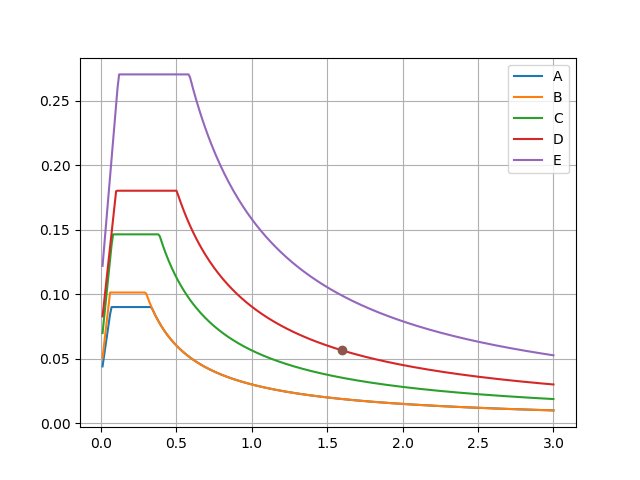

In [12]:
T_max = max(3.0, 1.2 * T_code_s)
lim = round(T_max * 100) + 1
T_range = [0.01 * float(T) for T in range(1,lim)]

soil_classes = ['A', 'B', 'C', 'D', 'E']
S_a_ranges = [[S_a(T, S_s, S_1, s_c) for T in T_range] for s_c in soil_classes]

[plt.plot(T_range, S_a_range, label=s_c) for s_c, S_a_range in zip(soil_classes, S_a_ranges)]
plt.plot(T_code_s, S_a_g, marker = 'o')
plt.grid(True)
plt.legend(soil_classes)
plt.show()

## Storey Force Data
This relies on the data calculated previously. It is therefore important that the cells below be recalculated if changes are made above here.

In [13]:
# 
print('Structural Type is {}'.format(s_type))

W_kN = total_weight_kN
V_kN = S_a_g * W_kN
print('Base shear is {:,.0f} kN  (S_a is {:,.4f}g, W is {:,.0f}kN)\n'.format(V_kN, S_a_g, W_kN))

storey_force_coeff_list = storey_force_coeffs(storey_elevs_m, storey_weights_kN, k)
storey_loads_kN = storey_force_distribution(V_kN, storey_elevs_m, storey_weights_kN, k)

storey_shears_kN, storey_moments_kNm = storey_shear_moment(storey_loads_kN, storey_heights_m, False)

tit_f = '{:20s} {:9s} {:10s} {:10s} {:10s} {:10s} {:10s}'
print(tit_f.format('Storey', 'Elevs (m)', 'Weights (kN)', ' Coeffs ', 'Forces (kN)', 'Shears (kN)', 'Moments (kNm)'))
num_f = '{:20s} {:8.2f}   {:8,.0f}   {:8.4f}   {:8,.0f}   {:>10,.0f}   {:>10,.0f}'
[print(num_f.format(n, h, wt, c, f, s, m)) for n, h, wt, c, f, s, m in zip(storey_names, storey_elevs_m, storey_weights_kN, 
                           storey_force_coeff_list, storey_loads_kN, storey_shears_kN, storey_moments_kNm)];


Structural Type is C2
Base shear is 42,551 kN  (S_a is 0.0566g, W is 751,776kN)

Storey               Elevs (m) Weights (kN)  Coeffs    Forces (kN) Shears (kN) Moments (kNm)
Roof                   104.83     22,805     0.1106      4,707        4,707            0
Mechanical Floor        97.36     28,478     0.1232      5,242        9,948       35,159
L22                     93.85     21,010     0.0859      3,653       13,602       70,078
L21                     90.04     14,143     0.0542      2,306       15,908      121,901
L20                     86.53     14,158     0.0510      2,171       18,079      177,739
L19                     83.02     14,158     0.0478      2,036       20,115      241,196
L18                     79.51     14,158     0.0448      1,904       22,019      311,800
L17                     76.00     14,873     0.0438      1,865       23,885      389,088
L16                     72.49     15,066     0.0413      1,756       25,641      472,924
L15                     6

## Assessment

Building Types:
C1
C2

In [15]:
# Default Values
f_c_psi = 4000.0 # MPa table 4-2
f_y_ksi = 52 # MPa table 4-3
F_y = 24 # ksi table 4-4 & 4-5
E_s = 200.0  # GPa 
F_pe = 111.2 # kN 

# ASCE 7-10
## Section 12.8 Equivalent Lateral Force Procedure

$V  = C_S W$


$C_S = \frac{S_{DS}}{\left(R/I_e\right)}$ 

but need not exceed the following:

$C_S = \frac{S_{D1}}{T\left(R/I_e\right)}$ for $T \leq T_L$

$C_S = \frac{S_{D1} T_L}{T^2\left(R/I_e\right)}$ for $T>T_L$

$C_S$ shall not be less than:

$C_S = 0.044 S_{DS} I_e \geq 0.01$

Where $S_1 \geq 0.6g$, $C_S$ shall not be less than:

$C_S = \frac{0.5 S_1} {\left(R/I_e\right)} $

NB for periods less than $T_0$ the design spectral response acceleration $S_a$ the rising slope at short periods is given by:

$S_a = S_{DS} \left( 0.4 + 0.6 \frac{T}{T_0} \right) $  where $T_0$ is equal to $ 0.2 \frac{S_{D1}}{S_{DS}} $


In [ ]:
def C_s(S_D1, T, R, I_e, T_L = ):
    res = (S_D1*T_L/T**2 if T > T_L else (S_D1*/T if T > (S_D1/S_DS) else S_DS)) * I_e / R
    pass


def C_u_interp_func(S_D1): 
    """Coefficient for Upper Limit on Calculated Period (Table 12.8-1)"""
    return list_interp(S_D1, [0.1, 0.15, 0.2, 0.3, 0.4], [1.7, 1.6, 1.5, 1.4, 1.4])


C_t_dict = {'SMRF':(0.028,0.0724), 'CMRF':(0.016,0.0466), 'SEBF': (0.03,0.0731), 'SBRBF': (0.03,0.0731), 'other': (0.02,0.0488)}
C_t_imp_dict = {'SMRF':0.028, 'CMRF':0.016, 'SEBF': 0.03, 'SBRBF': 0.03, 'other': 0.02}
C_t_metric_dict = {'SMRF':0.0724, 'CMRF':0.0466, 'SEBF': 0.0731, 'SBRBF': 0.0731, 'other': 0.0488}
x_dict = {'SMRF':0.8, 'CMRF':0.9, 'SEBF': 0.75, 'SBRBF': 0.75, 'other': 0.75}

